In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# **Without Sentiment**

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf

In [3]:
df_stock_apple = yf.download('AAPL', start='2023-01-01', end='2024-02-14')

[*********************100%%**********************]  1 of 1 completed


In [4]:
df_stock_apple

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,130.279999,130.899994,124.169998,125.070000,124.048050,112117500
2023-01-04,126.889999,128.660004,125.080002,126.360001,125.327507,89113600
2023-01-05,127.129997,127.769997,124.760002,125.019997,123.998459,80962700
2023-01-06,126.010002,130.289993,124.889999,129.619995,128.560852,87754700
2023-01-09,130.470001,133.410004,129.889999,130.149994,129.086533,70790800
...,...,...,...,...,...,...
2024-02-07,190.639999,191.050003,188.610001,189.410004,188.912399,53439000
2024-02-08,189.389999,189.539993,187.350006,188.320007,187.825256,40962000
2024-02-09,188.649994,189.990005,188.000000,188.850006,188.594208,45155200


In [5]:
df_stock_apple = pd.DataFrame(df_stock_apple)

# Shift 'Open' column by one row to get the next day's open
next_day_open = df_stock_apple['Open'].shift(-1)

# Add the next day's open as a new column
df_stock_apple['Next Day Open'] = next_day_open
df_stock_apple.dropna(inplace=True)
df_stock_apple.head(5)

,Open,High,Low,Close,Adj Close,Volume,Next Day Open
Date,,,,,,,
2023-01-03,130.279999,130.899994,124.169998,125.070000,124.048050,112117500,126.889999
2023-01-04,126.889999,128.660004,125.080002,126.360001,125.327507,89113600,127.129997
2023-01-05,127.129997,127.769997,124.760002,125.019997,123.998459,80962700,126.010002
2023-01-06,126.010002,130.289993,124.889999,129.619995,128.560852,87754700,130.470001
2023-01-09,130.470001,133.410004,129.889999,130.149994,129.086533,70790800,130.259995


In [6]:
# df_stock_tesla = df_stock_tesla.iloc[::-1]

In [7]:
df_stock_apple.drop(columns=['Adj Close'], inplace=True)

## Splitting the columns for target variable

In [8]:
X= df_stock_apple.drop(columns=['Next Day Open'])
y=df_stock_apple['Next Day Open']

## Scaling

In [9]:
# Importing libraries
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [10]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# Define the column transformer
ct = make_column_transformer(
    (make_pipeline(KNNImputer(), StandardScaler()), slice(0, df_stock_apple.shape[1])),  # Apply to all columns
    remainder="passthrough"
)

# Fit and transform the data
scaled_data_X = ct.fit_transform(X)
scaled_X = pd.DataFrame(scaled_data_X, columns=X.columns)

scaler_y = StandardScaler()
scaled_y = scaler_y.fit_transform(y.values.reshape(-1, 1))

## Spliting the data into Train,Test

In [11]:
# Determine the index to split the data linearly
split_index = int(len(X) * 0.85)

# Split the data into training and testing sets
X_train = scaled_data_X[:split_index]
X_test = scaled_data_X[split_index:]
y_train = scaled_y[:split_index]
y_test = scaled_y[split_index:]

## Modeling

In [12]:
# Importing librarues
from sklearn.linear_model import (LinearRegression, ElasticNetCV, RidgeCV)
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

In [13]:
# Collecting the different type of estimators to select best regression model
estimators = {
    "lr": LinearRegression(),
    "lassocv": LassoCV(alphas=np.logspace(-5, -1, 100)),
    "ridge": RidgeCV(alphas=np.logspace(-5, -1, 100)),
    "elastic": ElasticNetCV(alphas=np.logspace(-5, 1, 100), l1_ratio=[.1, .5, .7, .9, .95, .99, 1]),
}

In [14]:
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt
import pandas as pd

results_dict = {'Estimator': [], 'R2 Mean': [], 'RMSE Mean': [], 'NRMSE Mean': []}

# Iterate over each estimator
for name, estimator in estimators.items():
    print(name)

    # Perform cross-validation
    cv_result = cross_validate(estimator, X_train, y_train, scoring=('r2', 'neg_root_mean_squared_error'), return_estimator=True, cv=10, verbose=2)

    # Extract R2 scores and RMSE scores
    r2_scores = cv_result['test_r2']
    rmse_scores = -cv_result['test_neg_root_mean_squared_error']

    # Calculate mean and standard deviation of scores
    r2_mean, r2_std = np.mean(r2_scores), np.std(r2_scores)
    rmse_mean, rmse_std = np.mean(rmse_scores), np.std(rmse_scores)

    # Calculate NRMSE
    y_true = scaled_y
    y_preds = -cv_result['test_neg_root_mean_squared_error']  # Negative RMSE from cross-validation
    mse = y_preds ** 2  # Convert negative RMSE to MSE
    nrmse = sqrt(mse.mean()) / (y_true.max() - y_true.min())  # NRMSE calculation

    # Append results to the dictionary
    results_dict['Estimator'].append(name)
    results_dict['R2 Mean'].append(round(r2_mean, 3))
    results_dict['RMSE Mean'].append(round(rmse_mean, 3))
    results_dict['NRMSE Mean'].append(round(nrmse, 3))

# Create DataFrame from the results dictionary
results_df = pd.DataFrame(results_dict)

lr
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
lassocv
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END ........

In [15]:
pip install xgboost

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd

In [17]:
estimators = {
    "RandomForest": {
        "model": RandomForestRegressor(),
        "params": {
            "n_estimators": [50, 100, 150],
            "max_depth": [None, 5, 10, 15]
        }
    },
    "DecisionTree": {
        "model": DecisionTreeRegressor(),
        "params": {
            "max_depth": [None, 5, 10, 15]
        }
    },
    "SVR": {
        "model": SVR(),
        "params": {
            "kernel": ['linear', 'rbf'],
            "C": [0.1, 1, 10]
        }
    },
    "XGBoost": {
        "model": XGBRegressor(),
        "params": {
            "max_depth": [3, 5, 7],
            "learning_rate": [0.1, 0.01, 0.001],
            "n_estimators": [50, 100, 200]
        }
    }
}

In [18]:
for name, estimator in estimators.items():
    print(name)
    grid_search = GridSearchCV(estimator["model"], estimator["params"], scoring=('r2', 'neg_root_mean_squared_error'), cv=10, refit='r2', verbose=2)
    grid_search.fit(scaled_X, scaled_y)

    r2_scores = grid_search.cv_results_['mean_test_r2']
    rmse_scores = -grid_search.cv_results_['mean_test_neg_root_mean_squared_error']

    # Calculate NRMSE
    y_true = scaled_y  # Assuming scaled_y is the true target variable
    y_preds = -grid_search.cv_results_['mean_test_neg_root_mean_squared_error']  # Negative RMSE from cross-validation
    mse = y_preds ** 2  # Convert negative RMSE to MSE
    nrmse = sqrt(mse.mean()) / (y_true.max() - y_true.min())  # NRMSE calculation

    results_dict['Estimator'].append(name)
    results_dict['R2 Mean'].append(round(np.mean(r2_scores), 3))
    results_dict['RMSE Mean'].append(round(np.mean(rmse_scores), 3))
    results_dict['NRMSE Mean'].append(round(nrmse, 3))

RandomForest
Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.1s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.1s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.1s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.2s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.2s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.1s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.1s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.1s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.1s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.1s
[CV] END ...................max_depth=None, n_estimators=100; total time=   0.3s
[CV] END ...................max_d

In [19]:
results_df_without_sentiment = pd.DataFrame(results_dict)

# **With Sentiment**

In [20]:
import pandas as pd
from google.colab import drive
# Connecting to my google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
df_apple_final = pd.read_csv('/content/drive/MyDrive/606 project/df_apple_final_year.csv')

In [22]:
df_apple_final

,Open,High,Low,Close,Adj Close,Volume,date,mean_negative,count_negative,mean_positive,count_positive,mean_neutral,count_neutral,overall_mean_score,Next Day Open
0,130.279999,130.899994,124.169998,125.070000,124.216301,112117500,2023-01-03,0.434494,1053.0,0.511804,2190,0.000171,1647,0.135708,126.889999
1,126.889999,128.660004,125.080002,126.360001,125.497498,89113600,2023-01-04,0.427496,1094.0,0.514950,2202,0.000297,1666,0.134368,127.129997
2,127.129997,127.769997,124.760002,125.019997,124.166641,80962700,2023-01-05,0.431579,1185.0,0.531695,2732,0.000036,1827,0.163864,126.010002
3,126.010002,130.289993,124.889999,129.619995,128.735229,87754700,2023-01-06,0.429003,1011.0,0.520455,2042,0.000072,1606,0.135043,130.470001
4,130.470001,133.410004,129.889999,130.149994,129.261627,70790800,2023-01-09,0.424657,1147.0,0.528409,2554,0.000313,1835,0.155898,130.259995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,186.860001,189.309998,186.770004,189.300003,189.058762,43490800,2024-02-06,0.425243,1420.0,0.510556,2681,0.000112,1934,0.126789,190.639999
274,190.639999,191.050003,188.610001,189.410004,189.168625,53439000,2024-02-07,0.421259,1354.0,0.502710,2400,0.000034,1978,0.110988,189.389999
275,189.389999,189.539993,187.350006,188.320007,188.080017,40962000,2024-02-08,0.425625,1673.0,0.502108,3268,0.000047,2699,0.121590,188.649994
276,188.649994,189.990005,188.000000,188.850006,188.850006,45155200,2024-02-09,0.433370,1306.0,0.517975,2354,0.000203,2010,0.115298,188.419998


In [23]:
df_apple_final.drop(columns=['Adj Close'], inplace=True)

## Splitting the columns for target variable

In [24]:
X= df_apple_final.drop(columns=['Next Day Open'])
y=df_apple_final['Next Day Open']

In [25]:
y

0      126.889999
1      127.129997
2      126.010002
3      130.470001
4      130.259995
          ...    
273    190.639999
274    189.389999
275    188.649994
276    188.419998
277    185.770004
Name: Next Day Open, Length: 278, dtype: float64

## Scaling

In [26]:
# Importing libraries
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [27]:
dates = X['date']
X = X.drop(columns=['date'])

In [28]:
# Define the column transformer
ct = make_column_transformer(
    (make_pipeline(KNNImputer(), StandardScaler()), slice(0, df_apple_final.shape[1])),  # Apply to all columns
    remainder="passthrough"
)

# Fit and transform the data
scaled_data_X = ct.fit_transform(X)
scaled_X = pd.DataFrame(scaled_data_X, columns=X.columns)

scaler_y = StandardScaler()
scaled_y = scaler_y.fit_transform(y.values.reshape(-1, 1))

## Spliting the data into Train,Test

In [29]:
# Determine the index to split the data linearly
split_index = int(len(X) * 0.9)

# Split the data into training and testing sets
X_train = scaled_data_X[:split_index]
X_test = scaled_data_X[split_index:]
y_train = scaled_y[:split_index]
y_test = scaled_y[split_index:]

## Modeling with sentiment

In [30]:
# Importing librarues
from sklearn.linear_model import (LinearRegression, ElasticNetCV, RidgeCV)
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

In [31]:
# Collecting the different type of estimators to select best regression model
estimators1 = {
    "lr": LinearRegression(),
    "lassocv": LassoCV(alphas=np.logspace(-5, -1, 100)),
    "ridge": RidgeCV(alphas=np.logspace(-5, -1, 100)),
    "elastic": ElasticNetCV(alphas=np.logspace(-5, 1, 100), l1_ratio=[.1, .5, .7, .9, .95, .99, 1]),
}

In [32]:
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt
import pandas as pd

# Initialize an empty dictionary to store results
results_dict = {'Estimator': [], 'R2 Mean': [], 'RMSE Mean': [], 'NRMSE Mean': []}

# Iterate over each estimator
for name, estimator in estimators1.items():
    print(name)

    # Perform cross-validation
    cv_result = cross_validate(estimator, scaled_X, scaled_y, scoring=('r2', 'neg_root_mean_squared_error'), return_estimator=True, cv=10, verbose=2)

    # Extract R2 scores and RMSE scores
    r2_scores = cv_result['test_r2']
    rmse_scores = -cv_result['test_neg_root_mean_squared_error']

    # Calculate mean and standard deviation of scores
    r2_mean, r2_std = np.mean(r2_scores), np.std(r2_scores)
    rmse_mean, rmse_std = np.mean(rmse_scores), np.std(rmse_scores)

    # Calculate NRMSE
    y_true = scaled_y
    y_preds = -cv_result['test_neg_root_mean_squared_error']  # Negative RMSE from cross-validation
    mse = y_preds ** 2  # Convert negative RMSE to MSE
    nrmse = sqrt(mse.mean()) / (y_true.max() - y_true.min())  # NRMSE calculation

    # Append results to the dictionary
    results_dict['Estimator'].append(name)
    results_dict['R2 Mean'].append(round(r2_mean, 3))
    results_dict['RMSE Mean'].append(round(rmse_mean, 3))
    results_dict['NRMSE Mean'].append(round(nrmse, 3))

# Create DataFrame from the results dictionary
results_df = pd.DataFrame(results_dict)

lr
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
lassocv
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END ........

In [33]:
pip install xgboost

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd

In [35]:
estimators = {
    "RandomForest": {
        "model": RandomForestRegressor(),
        "params": {
            "n_estimators": [50, 100, 150],
            "max_depth": [None, 5, 10, 15]
        }
    },
    "DecisionTree": {
        "model": DecisionTreeRegressor(),
        "params": {
            "max_depth": [None, 5, 10, 15]
        }
    },
    "SVR": {
        "model": SVR(),
        "params": {
            "kernel": ['linear', 'rbf'],
            "C": [0.1, 1, 10]
        }
    },
    "XGBoost": {
        "model": XGBRegressor(),
        "params": {
            "max_depth": [3, 5, 7],
            "learning_rate": [0.1, 0.01, 0.001],
            "n_estimators": [50, 100, 200]
        }
    }
}

In [36]:
for name, estimator in estimators.items():
    print(name)
    grid_search = GridSearchCV(estimator["model"], estimator["params"], scoring=('r2', 'neg_root_mean_squared_error'), cv=10, refit='r2', verbose=2)
    grid_search.fit(scaled_X, scaled_y)

    r2_scores = grid_search.cv_results_['mean_test_r2']
    rmse_scores = -grid_search.cv_results_['mean_test_neg_root_mean_squared_error']

    # Calculate NRMSE
    y_true = scaled_y  # Assuming scaled_y is the true target variable
    y_preds = -grid_search.cv_results_['mean_test_neg_root_mean_squared_error']  # Negative RMSE from cross-validation
    mse = y_preds ** 2  # Convert negative RMSE to MSE
    nrmse = sqrt(mse.mean()) / (y_true.max() - y_true.min())  # NRMSE calculation

    results_dict['Estimator'].append(name)
    results_dict['R2 Mean'].append(round(np.mean(r2_scores), 3))
    results_dict['RMSE Mean'].append(round(np.mean(rmse_scores), 3))
    results_dict['NRMSE Mean'].append(round(nrmse, 3))

RandomForest
Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.2s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.2s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.4s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.2s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.4s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.4s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.4s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.3s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.2s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.3s
[CV] END ...................max_depth=None, n_estimators=100; total time=   0.8s
[CV] END ...................max_d

In [37]:
results_df_with_sentiment = pd.DataFrame(results_dict)

In [38]:
results_df_with_sentiment

,Estimator,R2 Mean,RMSE Mean,NRMSE Mean
0,lr,0.866,0.077,0.019
1,lassocv,0.871,0.075,0.018
2,ridge,0.868,0.077,0.019
3,elastic,0.871,0.075,0.018
4,RandomForest,0.612,0.155,0.037
5,DecisionTree,0.459,0.177,0.042
6,SVR,0.317,0.176,0.047
7,XGBoost,-4.422,0.479,0.134


In [39]:
results_df_without_sentiment

,Estimator,R2 Mean,RMSE Mean,NRMSE Mean
0,lr,0.841,0.090,0.022
1,lassocv,0.877,0.081,0.020
2,ridge,0.849,0.088,0.021
3,elastic,0.877,0.081,0.020
4,RandomForest,0.559,0.161,0.038
5,DecisionTree,0.457,0.176,0.042
6,SVR,0.248,0.188,0.050
7,XGBoost,-4.473,0.480,0.134


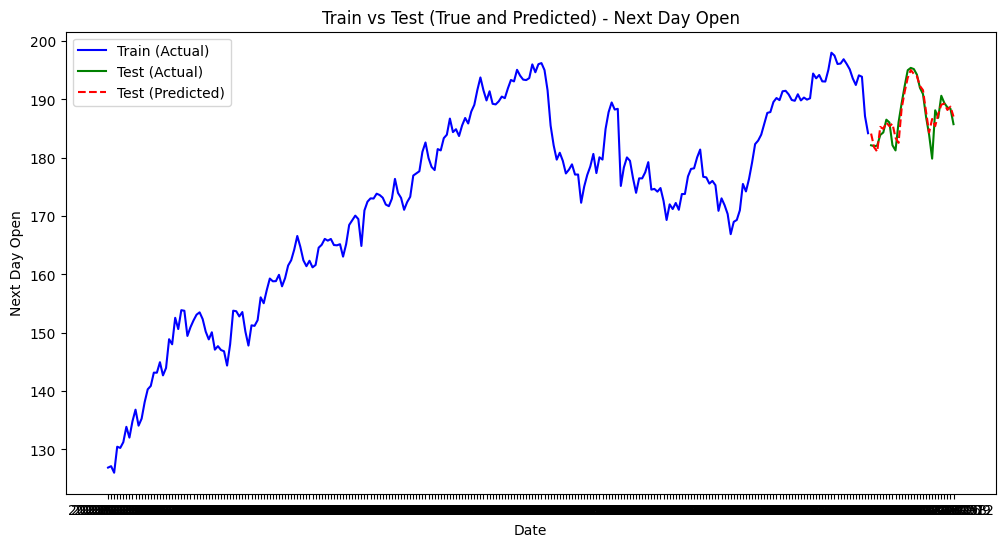

In [40]:
import pickle

# Train an ElasticNet model
elastic_model = ElasticNetCV(
    alphas=np.logspace(-5, 1, 100),
    l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]
)
elastic_model.fit(X_train, y_train)

# Save the model to a pickle file
with open("elastic_model.pkl", "wb") as f:
    pickle.dump(elastic_model, f)

# Make predictions on the test set
predicted_scaled_y = elastic_model.predict(X_test)

# Unscale the predicted and test values
predicted_y = scaler_y.inverse_transform(predicted_scaled_y.reshape(-1, 1))
y_test_unscaled = scaler_y.inverse_transform(y_test)

# Create a DataFrame to hold the date and actual/predicted values
df_plot = pd.DataFrame({
    "Date": df_apple_final["date"],
    "Actual": y.values,  # Original target values
    "Train/Test": ["Train"] * split_index + ["Test"] * (len(X) - split_index),
    "Predicted": np.nan  # Start with NaNs, fill with predictions later
})

# Insert predictions into the DataFrame for the test set
df_plot.loc[split_index:, "Predicted"] = predicted_y.flatten()

# Plot the line graph
plt.figure(figsize=(12, 6))

# Plot the training data
plt.plot(df_plot[df_plot["Train/Test"] == "Train"]["Date"], df_plot[df_plot["Train/Test"] == "Train"]["Actual"],
         label="Train (Actual)", linestyle='-', color='b')

# Plot the test data (true values)
plt.plot(df_plot[df_plot["Train/Test"] == "Test"]["Date"], df_plot[df_plot["Train/Test"] == "Test"]["Actual"],
         label="Test (Actual)", linestyle='-', color='g')

# Plot the test data (predicted values)
plt.plot(df_plot[df_plot["Train/Test"] == "Test"]["Date"], df_plot[df_plot["Train/Test"] == "Test"]["Predicted"],
         label="Test (Predicted)", linestyle='--', color='r')

# Add labels and titles
plt.xlabel("Date")
plt.ylabel("Next Day Open")
plt.title("Train vs Test (True and Predicted) - Next Day Open")
plt.legend()
plt.show()


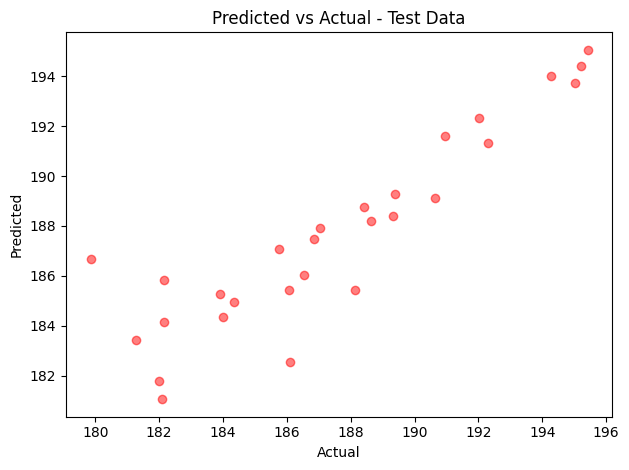

In [41]:
# 2. Scatter plot of Predicted vs Actual on the test set
plt.scatter(df_plot[df_plot["Train/Test"] == "Test"]["Actual"], df_plot[df_plot["Train/Test"] == "Test"]["Predicted"],
            alpha=0.5, color='r')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual - Test Data")
# Show the plots
plt.tight_layout()
plt.show()

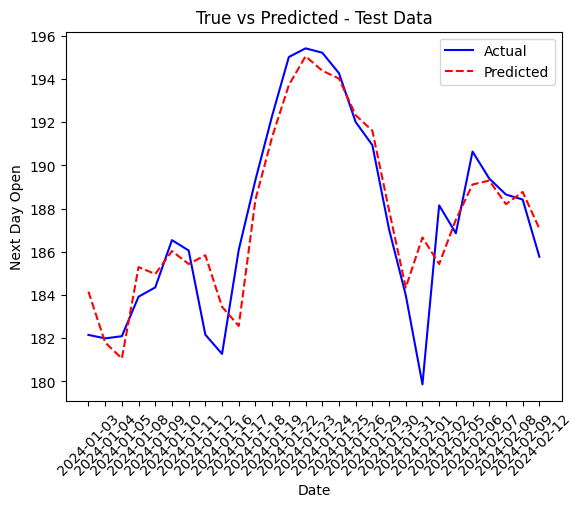

In [42]:
# 3. Line plot of True vs. Predicted Next Day Open
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.plot(df_plot[df_plot["Train/Test"] == "Test"]["Date"], df_plot[df_plot["Train/Test"] == "Test"]["Actual"],
         label="Actual", linestyle='-', color='b')
plt.plot(df_plot[df_plot["Train/Test"] == "Test"]["Date"], df_plot[df_plot["Train/Test"] == "Test"]["Predicted"],
         label="Predicted", linestyle='--', color='r')
plt.xlabel("Date")
plt.ylabel("Next Day Open")
plt.title("True vs Predicted - Test Data")
plt.legend()
plt.show()

We have achieved impressive prediction scores, but we haven't observed significant differences in prediction results between stocks with sentiments and those without. Therefore, we are opting for an LSTM model to delve deeper. LSTM models are specifically designed to capture temporal dependencies in data. Consequently, we will include the date or timestamp column along with other features as input, allowing the model to learn patterns over time.